In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Following code is referred from: 
# https://bitbucket.org/noblelab/2019_mmd_wabi/src/master/manifoldAlignDistortionPen_mmd_multipleStarts.py

def compute_pairwise_distances(x, y):
  
  if not len(x.get_shape()) == len(y.get_shape()) == 2:
    raise ValueError('Both inputs should be matrices.')

  if x.get_shape().as_list()[1] != y.get_shape().as_list()[1]:
    raise ValueError('The number of features should be the same.')

  norm = lambda x: tf.reduce_sum(tf.square(x), 1)

  return tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))


In [4]:
def gaussian_kernel_matrix(x, y, sigmas):
  """Computes a Guassian Radial Basis Kernel between the samples of x and y.
  We create a sum of multiple gaussian kernels each having a width sigma_i.
  Args:
    x: a tensor of shape [num_samples, num_features]
    y: a tensor of shape [num_samples, num_features]
    sigmas: a tensor of floats which denote the widths of each of the
      gaussians in the kernel.
  Returns:
    A tensor of shape [num_samples{x}, num_samples{y}] with the RBF kernel.
  """
  beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))

  dist = compute_pairwise_distances(x, y)

  s = tf.matmul(beta, tf.reshape(dist, (1, -1)))

  return tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))

In [5]:
def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix, bandwidth=1.0):
  """Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.
  Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of
  the distributions of x and y. Here we use the kernel two sample estimate
  using the empirical mean of the two distributions.
  MMD^2(P, Q) = || \E{\phi(x)} - \E{\phi(y)} ||^2
              = \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) },
  where K = <\phi(x), \phi(y)>,
    is the desired kernel function, in this case a radial basis kernel.
  Args:
      x: a tensor of shape [num_samples, num_features]
      y: a tensor of shape [num_samples, num_features]
      kernel: a function which computes the kernel in MMD. Defaults to the
              GaussianKernelMatrix.
  Returns:
      a scalar denoting the squared maximum mean discrepancy loss.
  """
  with tf.name_scope('MaximumMeanDiscrepancy'):
    # \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) }
    cost = tf.reduce_mean(kernel(x, x, tf.constant([bandwidth])))
    cost += tf.reduce_mean(kernel(y, y, tf.constant([bandwidth])))
    cost -= 2 * tf.reduce_mean(kernel(x, y, tf.constant([bandwidth])))

    # We do not allow the loss to become negative.
    cost = tf.where(cost > 0, cost, 0, name='value')
  return cost

In [39]:
f1='GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv'
f2='GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv'

tradeoff2 = 0.01
tradeoff3 = 0.001
p=2
bandwidth = 1.0
training_rate = 0.00005
k = 0

df=pd.read_csv(f1,sep='\t')
temp=np.array(df)
from sklearn.metrics.pairwise import cosine_similarity
k1_matrix =cosine_similarity(temp.T, Y=None, dense_output=True)

df=pd.read_csv(f2,sep='\t')
temp=np.array(df)
from sklearn.metrics.pairwise import cosine_similarity
k2_matrix =cosine_similarity(temp.T, Y=None, dense_output=True)

In [40]:
I_p=tf.eye(p)
record = open('loss.txt', 'w')
n1 = k1_matrix.shape[0]
n2 = k2_matrix.shape[0]
K1 = tf.constant(k1_matrix, dtype=tf.float32)
K2 = tf.constant(k2_matrix, dtype=tf.float32)
alpha = tf.Variable(tf.random.uniform([n1,p],minval=0.0,maxval=0.1,seed=k))
beta = tf.Variable(tf.random.uniform([n2,p],minval=0.0,maxval=0.1,seed=k))



In [42]:
# myFunction = tradeoff1*maximum_mean_discrepancy(tf.matmul(K1,alpha), tf.matmul(K2,beta)) + tradeoff2*(tf.norm(tf.subtract(tf.matmul(tf.transpose(alpha),tf.matmul(K1,alpha)),I_p),ord=2) + tf.norm(tf.subtract(tf.matmul(tf.transpose(beta),tf.matmul(K2,beta)),I_p),ord=2)) + tradeoff3*(tf.norm(tf.subtract(tf.matmul(tf.matmul(K1,alpha),tf.matmul(tf.transpose(alpha),tf.transpose(K1))),K1),ord=2)+tf.norm(tf.subtract(tf.matmul(tf.matmul(K2,beta),tf.matmul(tf.transpose(beta),tf.transpose(K2))),K2),ord=2))
mmd_part = maximum_mean_discrepancy(tf.matmul(K1,alpha), tf.matmul(K2,beta), bandwidth=bandwidth)
penalty_part = tradeoff2*(tf.norm(tf.subtract(tf.matmul(tf.transpose(alpha),tf.matmul(K1,alpha)),I_p),ord=2) + tf.norm(tf.subtract(tf.matmul(tf.transpose(beta),tf.matmul(K2,beta)),I_p),ord=2))
distortion_part = tradeoff3*(tf.norm(tf.subtract(tf.matmul(tf.matmul(K1,alpha),tf.matmul(tf.transpose(alpha),tf.transpose(K1))),K1),ord=2)+tf.norm(tf.subtract(tf.matmul(tf.matmul(K2,beta),tf.matmul(tf.transpose(beta),tf.transpose(K2))),K2),ord=2))
myFunction = mmd_part + penalty_part + distortion_part
train_step =  tf.train.AdamOptimizer(training_rate).minimize(myFunction)



In [45]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for i in range(10001):
  sess.run(train_step)
  if (i%2000==0): 
    np.savetxt("C:/Users/sumee/Desktop/ml in bio/final exam/alpha beta files/alpha_hat_"+str(k)+"_"+str(i)+".txt", sess.run(alpha))
    np.savetxt("C:/Users/sumee/Desktop/ml in bio/final exam/alpha beta files/beta_hat_"+str(k)+"_"+str(i)+".txt", sess.run(beta))
    rec = '\t'.join([str(k), str(i), str(sess.run(myFunction)), str(sess.run(mmd_part)), str(sess.run(penalty_part)), str(sess.run(distortion_part))])  
    record.write(rec + '\n')
    #print i
    print(sess.run(myFunction))

553.7724
0.19704302
0.18665096
0.17155461
0.15979752
0.15446323


In [4]:
f1='GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv'
f2='GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv'
f=open('C:/Users/sumee/Desktop/ml in bio/final exam/alpha beta files/alpha_hat_0_10000.txt','r')
mmd=[]
for l in f:
    mmd.append([float(l.split(' ')[0]),float(l.split(' ')[1])])
mmd=np.array(mmd)   
df=pd.read_csv(f1,sep='\t')
temp=np.array(df)
rna_points=temp@mmd
rna_points=np.array(rna_points)

f=open('C:/Users/sumee/Desktop/ml in bio/final exam/alpha beta files/beta_hat_0_10000.txt','r')
mmd=[]
for l in f:
    mmd.append([float(l.split(' ')[0]),float(l.split(' ')[1])])
mmd=np.array(mmd)   
df=pd.read_csv(f2,sep='\t')
temp=np.array(df)
atac_points=temp@mmd
atac_points=np.array(atac_points)

In [5]:
rna_points.shape

(18666, 2)

In [6]:
atac_points.shape

(136771, 2)

In [16]:
x=[i[0] for i in atac_points]
y=[i[1] for i in atac_points]

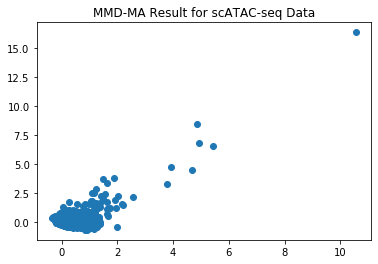

In [17]:
import  matplotlib.pyplot as plt
plt.scatter(x,y)
plt.title('MMD-MA Result for scATAC-seq Data')
plt.savefig('atac mmd-ma.png')

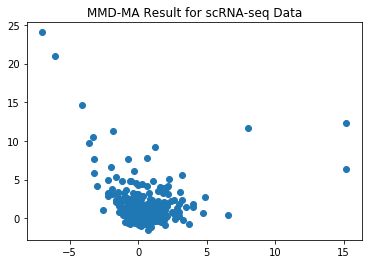

In [18]:
x=[i[0] for i in rna_points]
y=[i[1] for i in rna_points]
import  matplotlib.pyplot as plt
plt.scatter(x,y)
plt.title('MMD-MA Result for scRNA-seq Data')
plt.savefig('rna mmd-ma.png')